Statistics vademecum:
* **Precision**: fraction of true positives over all positives.
\begin{equation}
P = \frac{T_p}{T_p+F_p}
\end{equation}
* **Recall**: fraction of true positives over all "trues", i.e. true positives and false negatives.
\begin{equation}
R = \frac{T_p}{T_p+F_n}
\end{equation}
* **$F_1$ score**: harmonic mean of precision and recall.
\begin{equation}
F_1 = 2\frac{PR}{P+R}
\end{equation}

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from matplotlib import pyplot as plt
import h5py
import time
import joblib

from sklearn import ensemble, metrics, inspection, model_selection

In [2]:
# If true, perform a new grid search and overwrite the previous result
# If not, load existing results
do_grid_search = True

# name of the file where cross validation results are written/read
cv_results_file_name = 'BDT_cv_results.csv'

In [3]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

# Monte Carlo data
## Reconstructed events

In [4]:
inputMC = 'data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
tickMC = time.perf_counter()
df_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tockMC = time.perf_counter()
print(f"Monte Carlo imported in {tockMC - tickMC:0.4f} seconds.")

Monte Carlo imported in 15.7480 seconds.


In [5]:
print("Tot. MC events:", len(df_reco))

Tot. MC events: 366396


In [6]:
print(*list(df_reco), sep='\n')

Lb_ENDVERTEX_X
Lb_ENDVERTEX_Y
Lb_ENDVERTEX_Z
L_ENDVERTEX_X
L_ENDVERTEX_Y
L_ENDVERTEX_Z
Jpsi_ENDVERTEX_X
Jpsi_ENDVERTEX_Y
Jpsi_ENDVERTEX_Z
L_PX
L_PY
L_PZ
Lb_PX
Lb_PY
Lb_PZ
Jpsi_PX
Jpsi_PY
Jpsi_PZ
p_PX
p_PY
p_PZ
pim_PX
pim_PY
pim_PZ
mum_PX
mum_PY
mum_PZ
mup_PX
mup_PY
mup_PZ
L_M
L_MM
Lb_M
Lb_MM
Jpsi_M
Jpsi_MM
Lb_BPVDIRA
Lb_BPVIPCHI2
Lb_BPVVDCHI2
Lb_VFASPF_CHI2_VDOF
L_BPVDIRA
L_BPVIPCHI2
L_BPVVDCHI2
L_VFASPF_CHI2_VDOF
Lb_OWNPV_X
Lb_OWNPV_Y
Lb_OWNPV_Z
Lb_OWNPV_CHI2
Lb_OWNPV_NDOF
L_ID
Lb_ID
Jpsi_ID
p_ID
pim_ID
mum_ID
mup_ID
DTF_FixJPsi_status
DTF_FixJPsi_Lb_M
DTF_FixJPsi_Lb_P
DTF_FixJPsi_chi2
DTF_FixJPsi_nDOF
DTF_FixJPsi_PV_key
DTF_FixJPsi_PV_X
DTF_FixJPsi_PV_Y
DTF_FixJPsi_PV_Z
DTF_FixJPsi_L_M
DTF_FixJPsi_L_P
DTF_FixJPsi_L_decayLength
DTF_FixJPsi_pim_PX
DTF_FixJPsi_pim_PY
DTF_FixJPsi_pim_PZ
DTF_FixJPsi_p_PX
DTF_FixJPsi_p_PY
DTF_FixJPsi_p_PZ
DTF_FixJPsi_mum_PX
DTF_FixJPsi_mum_PY
DTF_FixJPsi_mum_PZ
DTF_FixJPsi_mup_PX
DTF_FixJPsi_mup_PY
DTF_FixJPsi_mup_PZ
DTF_FixJPsiLambda_status
DTF_FixJPsiLam

## Truth events

In [7]:
tickMCTruth = time.perf_counter()
df_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tockMCTruth = time.perf_counter()
print(f"Monte Carlo Truth imported in {tockMCTruth - tickMCTruth:0.4f} seconds.")

Monte Carlo Truth imported in 339.0028 seconds.


In [8]:
print("Tot. MCTruth events:", len(df_truth))

Tot. MCTruth events: 8921815


In [9]:
print(*list(df_truth), sep='\n')

MCTRUTH_Lb_ENDVERTEX_X
MCTRUTH_Lb_ENDVERTEX_Y
MCTRUTH_Lb_ENDVERTEX_Z
MCTRUTH_L_ENDVERTEX_X
MCTRUTH_L_ENDVERTEX_Y
MCTRUTH_L_ENDVERTEX_Z
MCTRUTH_p_PX
MCTRUTH_p_PY
MCTRUTH_p_PZ
MCTRUTH_pim_PX
MCTRUTH_pim_PY
MCTRUTH_pim_PZ
MCTRUTH_mum_PX
MCTRUTH_mum_PY
MCTRUTH_mum_PZ
MCTRUTH_mup_PX
MCTRUTH_mup_PY
MCTRUTH_mup_PZ
MCTRUTH_Lb_ID
MCTRUTH_L_ID
Lb_Reconstructible
Lb_Reconstructed
L_Reconstructible
L_Reconstructed
Jpsi_Reconstructible
Jpsi_Reconstructed
p_Reconstructible
p_Reconstructed
pim_Reconstructible
pim_Reconstructed
mum_Reconstructible
mum_Reconstructed
mup_Reconstructible
mup_Reconstructed
p_PP_X
p_PP_Y
p_PP_Z
p_PP_PX
p_PP_PY
p_PP_PZ
p_PP_Weight
pim_PP_X
pim_PP_Y
pim_PP_Z
pim_PP_PX
pim_PP_PY
pim_PP_PZ
pim_PP_Weight
mum_PP_X
mum_PP_Y
mum_PP_Z
mum_PP_PX
mum_PP_PY
mum_PP_PZ
mum_PP_Weight
mup_PP_X
mup_PP_Y
mup_PP_Z
mup_PP_PX
mup_PP_PY
mup_PP_PZ
mup_PP_Weight
Rec_key
N_rec_matches
TrackType


## Merge the dataframes

In [10]:
tickMerge = time.perf_counter()
df_MC = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_MC = df_MC.loc[(df_MC['MC_key'] >= 0) & (df_MC['Rec_key'] >= 0)]
tockMerge = time.perf_counter()
print(f"Monte Carlo merged in {tockMerge - tickMerge:0.4f} seconds.")

Monte Carlo merged in 5.2971 seconds.


In [11]:
df_MC

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.347290,23634.302734,T,0
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375,T,29
2,-0.4798,-0.7758,18.706800,-785.810974,-591.072998,5157.507812,-5172.310059,-3904.530029,34147.730469,-470.119995,...,-323.442810,2628.927246,4.108163,-790.314697,5651.807129,-5579.078613,-431.151581,23151.667969,T,69
3,1.6829,-2.2522,-36.520901,94.709503,-270.525391,3823.881348,5635.350098,-15984.469727,230495.453125,604.909973,...,-1702.511353,24506.517578,8712.822266,-18033.572266,231397.500000,336.531647,-3496.248779,45100.238281,T,119
5,2.2347,-3.0136,-3.515400,-41.785000,-495.398499,2890.112793,-144.789993,-1430.229980,8650.469727,-27.309999,...,-514.345398,2560.247559,2766.051025,-6544.098633,37503.421875,4405.509766,-5917.182129,27155.025391,T,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366391,0.9741,0.2091,-11.659000,294.090698,39.875000,7125.287109,2412.750000,405.109985,60216.011719,395.200012,...,-18.306223,7767.518555,1504.345581,715.472656,49351.718750,-112.221489,2933.706299,37641.914062,T,8921673
366392,-0.5103,1.2180,21.928400,-148.940399,123.715599,7319.557129,-1238.500000,978.909973,57653.351562,-45.599998,...,-50.586430,-2812.631592,-3547.666504,1885.741577,33505.289062,-1337.816284,1466.083374,45027.328125,T,8921702
366393,0.1275,-0.0589,25.113001,-123.851601,-28.034100,2985.664307,-6471.830078,-1487.530029,153226.906250,-561.440002,...,-133.646973,15975.192383,-3526.683594,-343.335175,44636.988281,-3534.635254,-3121.734619,91762.195312,T,8921772


## Apply pre-selection cuts matching data

In [12]:
JPsi1SPDGMass = 3096.900

PionPCuts = (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) > 2000) & (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) < 5e5)
ProtonPCuts = (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) > 10000) & (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) < 5e5)
ProtonPTCuts = TransverseMomentumModulus(df_MC['p_PX'], df_MC['p_PY']) > 400
## Combined m(p-pi)? Seems to be "AM" in the DaVinci opt file
LambdaMCuts = (df_MC['L_M'] > 600) & (df_MC['L_M'] < 1500)
LambdaMMCuts = df_MC['L_MM'] < 1500
LambdaZCuts = (df_MC['L_ENDVERTEX_Z'] > 5500) & (df_MC['L_ENDVERTEX_Z'] < 8500)
LambdaDiraCuts = (df_MC['L_BPVDIRA'] > 0.9999)
LambdaBPVIPCHI2Cuts = df_MC['L_BPVIPCHI2'] < 200
LambdaBPVVDCHI2Cuts = df_MC['L_BPVVDCHI2'] < 2e7
LambdaChi2Cuts = df_MC['L_VFASPF_CHI2_VDOF'] < 750
JPsiMCuts = abs(df_MC['Jpsi_M'] - JPsi1SPDGMass) < 90
LambdaPTCuts = TransverseMomentumModulus(df_MC['L_PX'], df_MC['L_PY']) > 450
## Combined m(JpsiLambda)? See comment above
LambdabMCuts = (df_MC['Lb_M'] < 8500)
LambdabDiraCuts = abs(df_MC['Lb_BPVDIRA']) > 0.99
LambdabBPVIPCHI2Cuts = df_MC['Lb_BPVIPCHI2'] < 1750
LambdabChi2Cuts = df_MC['Lb_VFASPF_CHI2_VDOF'] < 150

df_MC_Filtered = df_MC.loc[
    PionPCuts &
    ProtonPCuts &
    ProtonPTCuts &
    LambdaMCuts &
    LambdaMMCuts &
    LambdaZCuts &
    LambdaDiraCuts &
    LambdaBPVIPCHI2Cuts &
    LambdaBPVVDCHI2Cuts &
    LambdaChi2Cuts &
    JPsiMCuts &
    LambdaPTCuts &
    LambdabMCuts &
    LambdabDiraCuts &
    LambdabBPVIPCHI2Cuts &
    LambdabChi2Cuts
]

df_MC_Filtered

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.347290,23634.302734,T,0
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375,T,29
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,-151.918823,7139.517578,100.262436,999.515259,50033.699219,-120.737198,-995.344788,6822.337402,T,277
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,104.645416,10220.954102,-884.967468,195.843964,34903.839844,1645.699585,-1113.117432,24484.212891,T,367
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,20.153040,3543.737305,-829.315674,-926.117676,37815.328125,2614.833252,-1553.520630,63936.839844,T,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,-1059.302368,13806.107422,2310.392578,-2437.838867,42988.765625,2057.492432,-877.707703,10357.686523,T,8921400
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,-259.237457,19192.976562,1663.037476,477.534760,14450.500000,-812.013245,-604.744568,27734.162109,T,8921503
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,-295.752747,15403.834961,196.509079,-679.625732,6668.261719,3547.472900,-3286.872803,190998.375000,T,8921603


# Real data

In [13]:
inputData = 'data/Custom_Shuffled5e5_LHCbData_2016_MagUpDown_Dimuon_Ttracks.h5'

tickData = time.perf_counter()
df_Data = pd.read_hdf(inputData, key='LHCbData')
tockData = time.perf_counter()
print(f"Data imported found in {tockData - tickData:0.4f} seconds.")

Data imported found in 23.1533 seconds.


In [14]:
df_Data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_PV_key,DTF_FixJPsiLambda_PIDSubs_PV_X,DTF_FixJPsiLambda_PIDSubs_PV_Y,DTF_FixJPsiLambda_PIDSubs_PV_Z,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
0,0.741083,0.040052,51.522447,-183.292384,-43.859362,6490.082515,0.7439,0.0407,51.4959,-1962.289750,...,0.0,0.8736,-0.1967,48.166500,309.563354,-408.524475,34743.472656,-2211.389404,-110.629265,20956.490234
1,0.966530,1.056296,12.180388,460.300083,66.834128,7770.100444,0.9662,1.0572,12.2043,1394.350564,...,0.0,0.8501,-0.2092,-26.982300,1596.628906,3514.845459,104168.757812,-880.160461,658.744263,13403.822266
2,0.966233,1.057736,12.214956,-57.917475,-84.071053,5993.154473,0.9662,1.0572,12.2043,-428.321594,...,0.0,0.8501,-0.2092,-26.982300,1700.060669,3381.554932,100243.195312,-873.159973,657.834717,13182.185547
3,0.823661,0.118355,46.132318,618.389668,168.951341,7355.920185,0.8241,0.1180,46.1314,1451.342628,...,0.0,0.7951,-0.1776,44.437199,-1076.289917,1566.036987,8062.599609,2149.493652,2015.187012,11564.797852
4,1.115657,-0.125374,16.776287,238.067626,64.113430,7681.684115,1.1156,-0.1256,16.7798,2399.018104,...,0.0,0.8308,-0.2088,-5.163700,1367.081787,74.007980,38234.714844,-1429.765259,-1237.681396,38150.023438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502109,0.846524,-0.134417,32.394226,-64.169224,6.479162,5770.951530,0.8465,-0.1340,32.3945,-584.392519,...,0.0,0.8459,-0.1883,32.926998,556.332214,-1148.651367,10566.268555,512.927612,1943.064453,10574.164062
502110,0.871183,-0.286051,41.685312,34.181050,-103.878831,6986.884965,0.8709,-0.2864,41.6887,421.292007,...,0.0,0.8218,-0.2298,36.771099,445.235138,-514.793945,17956.791016,-2666.400391,-2992.653564,30364.205078
502111,0.870582,-0.286811,41.692622,-452.733867,61.078171,5891.824125,0.8709,-0.2864,41.6887,-3363.159232,...,0.0,0.8218,-0.2298,36.771099,468.523468,-513.491150,17915.718750,-2619.216064,-2997.929932,30253.095703
502112,-0.402430,-1.233937,-36.036206,-60.702877,89.445117,7273.999982,-0.3998,-1.2317,-36.0552,91.685951,...,0.0,0.8815,-0.2150,-45.118000,-9281.548828,-5284.185059,58504.699219,-1797.508667,-2812.620850,22225.533203


## Select side bands

In [15]:
df_Data_Sideband = df_Data.loc[df_Data['DTF_FixJPsiLambda_Lb_M'] > 5803]
df_Data_Sideband

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_PV_key,DTF_FixJPsiLambda_PIDSubs_PV_X,DTF_FixJPsiLambda_PIDSubs_PV_Y,DTF_FixJPsiLambda_PIDSubs_PV_Z,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
9,0.954203,-0.344464,-53.680211,-262.045608,0.442579,5510.941369,0.9542,-0.3443,-53.6797,-1782.133090,...,0.0,0.8468,-0.2622,-54.893501,437.180298,2096.835693,11598.041992,1090.466187,-844.338867,13521.172852
10,0.594506,1.091681,4.248750,-130.962451,-12.215099,7696.425393,0.5944,1.0918,4.2498,-542.173222,...,1.0,0.7767,-0.1859,-8.075300,246.036743,-837.566833,18804.574219,-324.927582,2296.204346,21652.119141
11,0.510916,-0.100533,2.469290,-115.172428,-15.312432,7416.775760,0.5115,-0.1005,2.4713,-1604.083225,...,0.0,0.8078,-0.1900,-11.636300,-1915.078979,397.245697,40416.109375,1053.967896,-473.800598,14331.053711
12,-3.018767,-1.877033,116.476465,228.699716,60.309666,7438.445918,-3.0203,-1.8776,116.4960,470.992288,...,1.0,0.8418,-0.2003,56.337399,-4871.875977,-1851.765503,51975.703125,-3758.903076,-2457.851807,81130.992188
15,0.821776,-0.194724,-98.650781,704.486275,-114.239457,6479.514135,0.8206,-0.1960,-98.6433,2103.247630,...,0.0,0.8000,-0.2197,-98.998703,601.174988,459.194885,9058.416992,-953.844238,-2465.735107,11614.083984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502096,0.879724,-0.135972,-41.057133,93.670514,7.303664,5570.798979,0.8800,-0.1366,-41.0625,464.499500,...,0.0,0.8832,-0.1605,-41.536201,-1089.839722,486.843903,8835.775391,-1582.450806,4219.804199,93952.031250
502104,0.765221,-0.124892,17.330386,216.976241,-2.940979,7724.294733,0.7632,-0.1235,17.3599,1791.506655,...,0.0,0.8249,-0.1796,16.311600,-1585.558838,3039.507324,45262.421875,-297.524719,-777.621033,12218.561523
502109,0.846524,-0.134417,32.394226,-64.169224,6.479162,5770.951530,0.8465,-0.1340,32.3945,-584.392519,...,0.0,0.8459,-0.1883,32.926998,556.332214,-1148.651367,10566.268555,512.927612,1943.064453,10574.164062
502110,0.871183,-0.286051,41.685312,34.181050,-103.878831,6986.884965,0.8709,-0.2864,41.6887,421.292007,...,0.0,0.8218,-0.2298,36.771099,445.235138,-514.793945,17956.791016,-2666.400391,-2992.653564,30364.205078


# Preliminary work for training
## Missing features
Add transverse momentum.

In [16]:
df_MC_Filtered = df_MC_Filtered.assign(
    p_PT = TransverseMomentumModulus(df_MC_Filtered['p_PX'],df_MC_Filtered['p_PY']),
    DTF_FixJPsiLambda_p_PT = TransverseMomentumModulus(df_MC_Filtered['DTF_FixJPsiLambda_p_PX'], df_MC_Filtered['DTF_FixJPsiLambda_p_PY']),
    pim_PT = TransverseMomentumModulus(df_MC_Filtered['pim_PX'],df_MC_Filtered['pim_PY']),
    DTF_FixJPsiLambda_pim_PT = TransverseMomentumModulus(df_MC_Filtered['DTF_FixJPsiLambda_pim_PX'], df_MC_Filtered['DTF_FixJPsiLambda_pim_PY']),
    Jpsi_PT = TransverseMomentumModulus(df_MC_Filtered['Jpsi_PX'],df_MC_Filtered['Jpsi_PY'])
)

Only for MC data frame, it's also necessary to replace DTF flags with numbers matching those in the real data.

In [17]:
successDictionaryReverse = {
    'Success': 0.0,
    'Failed': 1.0,
    'NonConverged': 3.0
}

df_MC_Filtered.replace({'DTF_FixJPsi_status': successDictionaryReverse}, inplace=True)
df_MC_Filtered.replace({'DTF_FixJPsiLambda_status': successDictionaryReverse}, inplace=True)
df_MC_Filtered

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key,p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,1438.071777,1619.347290,23634.302734,T,0,3670.964844,2733.329834,311.089020,334.741455,1259.644897
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,71.893692,-2873.631348,73489.484375,T,29,962.454834,1095.172607,292.199097,278.820038,2350.277832
8,0.5442,-0.4049,-30.064199,-237.463104,-161.438004,5029.397461,-1999.180054,-1447.800049,43812.398438,-599.280029,...,-120.737198,-995.344788,6822.337402,T,277,6069.714355,354.068542,313.657623,456.626129,16.075375
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,1645.699585,-1113.117432,24484.212891,T,367,3138.222168,2835.955811,563.971436,499.553711,1183.876953
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,2614.833252,-1553.520630,63936.839844,T,493,1088.444824,1326.820923,503.365540,192.515366,3060.318604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366374,1.9930,-0.9682,33.883499,454.162109,-444.944794,6047.499512,7053.950195,-6800.229980,92633.132812,949.369995,...,2057.492432,-877.707703,10357.686523,T,8921400,9575.651367,9594.823242,1461.105103,1428.191162,5488.212402
366378,1.2187,-0.0757,-10.080700,120.471603,-69.038300,7221.361328,1256.689941,-628.059998,71476.546875,189.229996,...,-812.013245,-604.744568,27734.162109,T,8921503,1055.863892,1963.163696,429.001678,352.585876,855.027405
366382,1.1575,-0.3940,43.910599,4.075100,-146.877396,7409.937500,133.949997,-2934.969971,147684.812500,-69.339996,...,3547.472900,-3286.872803,190998.375000,T,8921603,4872.735840,1022.928284,265.291748,294.877197,5446.465820


In [18]:
df_Data_Sideband = df_Data_Sideband.assign(
    p_PT = TransverseMomentumModulus(df_Data_Sideband['p_PX'],df_Data_Sideband['p_PY']),
    DTF_FixJPsiLambda_p_PT = TransverseMomentumModulus(df_Data_Sideband['DTF_FixJPsiLambda_p_PX'], df_Data_Sideband['DTF_FixJPsiLambda_p_PY']),
    pim_PT = TransverseMomentumModulus(df_Data_Sideband['pim_PX'],df_Data_Sideband['pim_PY']),
    DTF_FixJPsiLambda_pim_PT = TransverseMomentumModulus(df_Data_Sideband['DTF_FixJPsiLambda_pim_PX'], df_Data_Sideband['DTF_FixJPsiLambda_pim_PY']),
    Jpsi_PT = TransverseMomentumModulus(df_Data_Sideband['Jpsi_PX'],df_Data_Sideband['Jpsi_PY'])
)

df_Data_Sideband

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT
9,0.954203,-0.344464,-53.680211,-262.045608,0.442579,5510.941369,0.9542,-0.3443,-53.6797,-1782.133090,...,2096.835693,11598.041992,1090.466187,-844.338867,13521.172852,1904.555341,1646.064087,206.724964,304.202637,2016.683654
10,0.594506,1.091681,4.248750,-130.962451,-12.215099,7696.425393,0.5944,1.0918,4.2498,-542.173222,...,-837.566833,18804.574219,-324.927582,2296.204346,21652.119141,454.513704,5698.880371,78.775462,313.766510,1249.589483
11,0.510916,-0.100533,2.469290,-115.172428,-15.312432,7416.775760,0.5115,-0.1005,2.4713,-1604.083225,...,397.245697,40416.109375,1053.967896,-473.800598,14331.053711,1017.301236,1832.192627,690.887812,334.951111,854.123039
12,-3.018767,-1.877033,116.476465,228.699716,60.309666,7438.445918,-3.0203,-1.8776,116.4960,470.992288,...,-1851.765503,51975.703125,-3758.903076,-2457.851807,81130.992188,456.500463,956.089355,38.721189,44.764168,9530.580227
15,0.821776,-0.194724,-98.650781,704.486275,-114.239457,6479.514135,0.8206,-0.1960,-98.6433,2103.247630,...,459.194885,9058.416992,-953.844238,-2465.735107,11614.083984,2083.186475,45111.359375,354.375256,421.553406,2025.621167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502096,0.879724,-0.135972,-41.057133,93.670514,7.303664,5570.798979,0.8800,-0.1366,-41.0625,464.499500,...,486.843903,8835.775391,-1582.450806,4219.804199,93952.031250,440.130983,6789.666016,506.169549,1137.612183,5443.543081
502104,0.765221,-0.124892,17.330386,216.976241,-2.940979,7724.294733,0.7632,-0.1235,17.3599,1791.506655,...,3039.507324,45262.421875,-297.524719,-777.621033,12218.561523,1430.647395,3637.269775,414.150864,1282.703369,2924.919771
502109,0.846524,-0.134417,32.394226,-64.169224,6.479162,5770.951530,0.8465,-0.1340,32.3945,-584.392519,...,-1148.651367,10566.268555,512.927612,1943.064453,10574.164062,1423.279621,396.024902,327.216236,185.857224,1345.985452
502110,0.871183,-0.286051,41.685312,34.181050,-103.878831,6986.884965,0.8709,-0.2864,41.6887,421.292007,...,-514.793945,17956.791016,-2666.400391,-2992.653564,30364.205078,792.898343,820.907776,630.490371,411.936798,4155.462143


In [19]:
features = [
    'p_PT',
    'p_PZ',
    'pim_PT',
    'pim_PZ',
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status']

In [20]:
featureLabels = {
    'p_PT': '$p_T(p)$',
    'p_PZ': '$p_z(p)$',
    'pim_PT': '$p_T(\pi)$',
    'pim_PZ': '$p_z(\pi)$',
    'Jpsi_PT': '$p_T(J/\psi)$',
    'Jpsi_PZ': '$p_z(J/\psi)$',
    'L_ENDVERTEX_X': '$x_{vtx}^\Lambda$',
    'L_ENDVERTEX_Y': '$y_{vtx}^\Lambda$',
    'L_ENDVERTEX_Z': '$z_{vtx}^\Lambda$',
    'L_BPVDIRA': r'$\cos\theta_{\Lambda}$',
    'Lb_BPVDIRA': r'$\cos\theta_{\Lambda_b}$',
    'L_VFASPF_CHI2_VDOF': '$\chi^2_{vtx}(\Lambda)$',
    'Lb_VFASPF_CHI2_VDOF': '$\chi^2_{vtx}(\Lambda_b)$',
    'L_BPVIPCHI2': '$\chi^2_{PV}(\Lambda)$',
    'Lb_BPVIPCHI2': '$\chi^2_{PV}(\Lambda_b)$',
    'L_BPVVDCHI2': '$\chi^2_{dist}(\Lambda)$',
    'Lb_BPVVDCHI2': '$\chi^2_{dist}(\Lambda_b)$',
    'DTF_FixJPsi_status': 'DTF status ($J\psi$ mass constraint)',
    'DTF_FixJPsiLambda_status': 'DTF status ($J\psi \Lambda$ mass constraint)'
}

## Train and test data
### Signal data (type 1)

Sample 100% of signal. That is, scramble the data frame.

In [21]:
df_signal = df_MC_Filtered.sample(frac=1, random_state=98)
df_signal['TYPE'] = 1
df_signal

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key,p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,TYPE
Rec_key,,,,,,,,,,,,,,,,,,,,,
352003,0.9900,0.0169,3.300000,116.388496,30.117701,6282.886719,1290.660034,252.080002,66415.468750,197.050003,...,-641.391113,19495.591797,T,8575751,1499.261230,1339.061157,142.576462,239.662476,3483.928467,1
265235,1.0184,0.1609,39.636501,962.438599,463.805511,7189.831543,8050.549805,3783.229980,59438.179688,1006.159973,...,3637.840332,55652.945312,T,6484636,6531.696777,7250.666016,1098.382568,1083.654663,8100.985840,1
148181,0.7204,-0.3519,57.459000,-193.378693,-403.258698,6942.271973,-1085.930054,-2357.689941,41237.300781,-240.050003,...,1025.370605,48962.398438,T,3663879,1195.592285,2590.605225,600.855042,474.126373,314.042480,1
142519,3.3923,0.6250,-4.199400,938.192383,191.425995,5742.935547,10825.129883,2139.020020,66201.109375,1162.140015,...,65.273163,17206.941406,T,3529217,8357.870117,10886.081055,954.039429,1106.244019,6472.403320,1
242204,0.8681,1.4937,8.098100,-151.000793,112.281601,4932.158691,-1066.640015,852.979980,33873.550781,-219.490005,...,3946.147217,48469.367188,T,5933505,931.300659,1152.498901,812.275085,289.336945,4190.266602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254053,0.8669,0.1186,-20.466700,-109.663101,-47.713299,7491.895508,-818.690002,-339.369995,49225.160156,-17.280001,...,1600.304932,23268.414062,T,6216172,736.067566,866.862000,41.733448,29.015322,2405.740723,1
82685,1.2139,-0.9886,80.126602,256.224915,-405.731506,6392.206543,2266.000000,-3699.520020,58149.429688,662.109985,...,-2979.935547,43434.093750,T,2048916,4044.346680,4354.338379,1076.822876,1156.929077,2567.075439,1
325358,1.3912,0.3859,82.847298,543.844421,-61.370899,5650.757324,2838.750000,-257.529999,29827.970703,657.669983,...,712.099365,24441.621094,T,7930482,3212.848877,2977.199707,300.460205,571.568848,4692.720215,1


### Sidebands (type 0)

In [22]:
df_background  = df_Data_Sideband.sample(frac=1, random_state=98)
df_background['TYPE'] = 0
df_background

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,TYPE
28897,0.642704,-0.484829,-19.538637,-66.521678,-41.245603,5718.943484,0.6430,-0.4841,-19.5435,-509.996756,...,7136.488770,-1850.011841,-4024.802979,47781.570312,1163.196581,155.039932,410.491535,9232.249023,4941.192695,0
459044,0.949720,0.141961,-17.777687,-58.294443,-161.454433,7014.824834,0.9509,0.1431,-17.7690,-957.007934,...,18252.222656,592.172791,1839.569092,12046.143555,1919.734870,7097.678711,1166.447101,1349.979004,1101.150685,0
185001,0.770393,0.028391,1.206817,-1261.291922,2.754168,7526.806847,0.7705,0.0283,1.2093,-2661.591285,...,10935.476562,1031.184448,-2603.352783,42431.714844,2032.556586,3546.886475,269.843432,97.409195,2028.476589,0
142856,0.829848,-0.246675,16.307852,98.091390,7.922506,6592.827375,0.8307,-0.2465,16.3120,1215.891286,...,8446.179688,-478.738068,-498.062378,34485.742188,564.124739,1476.258301,498.342746,58.872524,1176.263813,0
488176,1.000577,-0.004293,59.323659,152.458419,56.572256,7907.576215,0.9890,0.0010,59.2685,475.039922,...,18037.322266,-20.829746,543.355103,6826.803223,451.150732,827.602844,60.362110,48.976830,3820.855353,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53960,0.769625,-0.137157,-1.921042,333.144757,-38.314677,7726.183021,0.7695,-0.1370,-1.9239,1414.586463,...,59942.222656,1640.821777,-1948.986938,38782.527344,645.364567,12712.377930,757.699363,5040.844727,2990.624457,0
192992,0.874200,-0.307568,8.344550,26.918351,102.189184,7123.010733,0.8658,-0.3103,8.3867,-25.430545,...,15444.047852,-273.093170,-446.432861,17866.273438,592.379896,1599.084717,315.389950,677.035889,3759.275156,0
105515,1.507326,-1.055930,53.047628,-57.905745,182.407189,7814.761008,1.5095,-1.0582,53.0698,-441.493965,...,37963.652344,1533.877563,-2071.187500,18043.048828,636.473898,7521.579102,799.192766,5866.992188,3322.858089,0
358893,0.774382,-0.002810,58.849712,-75.592934,149.248888,7464.667601,0.7751,-0.0029,58.8506,-527.174437,...,8977.818359,-1748.669922,259.170074,10938.573242,681.055386,986.649902,643.814391,1912.016602,613.784354,0


## Merge signal & background
Reserve 10% of data of testing purposes.

In [23]:
## Splitting points at 90% of the DF length
signalSplitPoint = int(len(df_signal) * 0.9)
backgroundSplitPoint = int(len(df_background) * 0.9)

In [24]:
df_train = pd.concat([df_signal.iloc[:signalSplitPoint], df_background.iloc[:backgroundSplitPoint]], ignore_index=True)
df_train.dropna('columns', inplace=True)
df_test = pd.concat([df_signal.iloc[signalSplitPoint:], df_background.iloc[backgroundSplitPoint:]], ignore_index=True)
df_test.dropna('columns', inplace=True)

In [25]:
df_train

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,TYPE
0,0.990684,0.038438,3.720320,117.838326,29.838898,6333.288086,0.9906,0.0386,3.717400,1307.867554,...,75179.382812,-954.128357,-641.391113,19495.591797,1499.261230,1339.061157,142.576462,239.662476,3483.928467,1
1,0.964242,0.134459,39.105392,1093.493652,531.495728,8164.981934,0.9644,0.1345,39.107300,7001.500977,...,22976.921875,5065.811035,3637.840332,55652.945312,6531.696777,7250.666016,1098.382568,1083.654663,8100.985840,1
2,0.675460,-0.328716,57.463936,-197.189377,-422.015839,7067.048828,0.6725,-0.3235,57.414001,-1354.853271,...,11271.579102,-65.253616,1025.370605,48962.398438,1195.592285,2590.605225,600.855042,474.126373,314.042480,1
3,3.361676,0.599952,-4.398020,988.086487,194.970932,6042.386719,3.3619,0.6001,-4.396900,10664.260742,...,24429.681641,1660.942749,65.273163,17206.941406,8357.870117,10886.081055,954.039429,1106.244019,6472.403320,1
4,0.867931,1.494975,8.201304,-180.168259,113.960808,5644.292969,0.8679,1.4951,8.201700,-1396.519409,...,13889.977539,344.370178,3946.147217,48469.367188,931.300659,1152.498901,812.275085,289.336945,4190.266602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228493,1.005732,-0.220347,32.988498,18.627730,116.665470,6149.815967,1.0062,-0.2201,32.990900,411.756683,...,8431.462891,-29.524315,-817.325439,20130.509766,1220.226567,1239.802612,1089.563873,584.398865,1239.946333,0
228494,0.804993,-0.173207,-13.192062,110.454714,60.595216,7083.125185,0.8049,-0.1732,-13.192500,1235.938957,...,48570.027344,1171.188232,-407.516663,6362.224121,1083.955904,892.092041,450.382581,346.130585,3907.140734,0
228495,1.151555,-0.098889,69.969779,-91.669910,-16.708251,7082.764803,1.1452,-0.0946,69.896100,-805.570901,...,42489.683594,-276.901367,-709.275146,21006.623047,567.501520,1658.590454,398.880250,94.031776,4557.561173,0
228496,0.785419,-0.684213,15.040096,49.366265,165.600026,7805.884814,0.7835,-0.6829,15.004600,390.427716,...,41657.515625,-112.497192,-1661.988892,72489.250000,758.780272,7304.916016,705.825113,5091.433594,234.577613,0


In [26]:
df_test

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,TYPE
0,1.253080,-0.013686,-23.442694,513.993103,355.759460,7081.937988,1.2531,-0.0137,-23.4426,2381.848145,...,6740.607910,4515.231934,1748.720703,28718.853516,2504.376465,2798.346191,416.471710,536.600769,5507.754883,1
1,0.668820,0.064336,-27.951580,-764.740417,714.845032,8306.612305,0.6686,0.0645,-27.9503,-5884.256348,...,18033.630859,70.930359,-774.841553,12357.408203,3678.204834,4010.383301,511.451996,497.234833,2331.964111,1
2,0.847229,0.204735,-13.084999,121.949402,790.637390,7902.954102,0.8472,0.2047,-13.0850,1033.767944,...,6063.832031,-1797.591675,2137.468750,16436.371094,6151.153320,3191.249023,908.855103,883.122070,2105.087891,1
3,0.713268,0.786892,-14.592052,-361.638855,867.828552,6799.666504,0.7133,0.7868,-14.5923,-1406.193359,...,14730.555664,1659.500854,2407.391602,11760.000977,2215.048828,3299.109375,1217.576172,1064.717407,5490.721191,1
4,0.448908,-0.015346,-23.151735,-175.256287,-99.867805,5772.698242,0.4490,-0.0154,-23.1549,-2125.384766,...,111201.039062,-1779.702271,2596.198486,111356.656250,1299.116333,1661.818237,1164.087158,573.867249,6432.109863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25385,0.769625,-0.137157,-1.921042,333.144757,-38.314677,7726.183021,0.7695,-0.1370,-1.9239,1414.586463,...,59942.222656,1640.821777,-1948.986938,38782.527344,645.364567,12712.377930,757.699363,5040.844727,2990.624457,0
25386,0.874200,-0.307568,8.344550,26.918351,102.189184,7123.010733,0.8658,-0.3103,8.3867,-25.430545,...,15444.047852,-273.093170,-446.432861,17866.273438,592.379896,1599.084717,315.389950,677.035889,3759.275156,0
25387,1.507326,-1.055930,53.047628,-57.905745,182.407189,7814.761008,1.5095,-1.0582,53.0698,-441.493965,...,37963.652344,1533.877563,-2071.187500,18043.048828,636.473898,7521.579102,799.192766,5866.992188,3322.858089,0
25388,0.774382,-0.002810,58.849712,-75.592934,149.248888,7464.667601,0.7751,-0.0029,58.8506,-527.174437,...,8977.818359,-1748.669922,259.170074,10938.573242,681.055386,986.649902,643.814391,1912.016602,613.784354,0


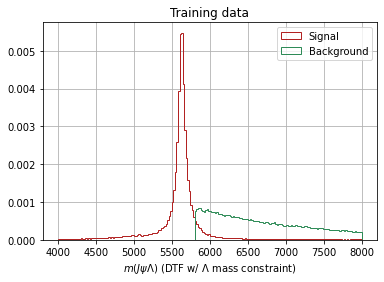

In [27]:
plt.hist(df_train.loc[df_train['TYPE'] == 1, 'DTF_FixJPsiLambda_Lb_M'],bins=200,range=(4000,8000),
        color='firebrick', label='Signal', density=True, histtype='step')
plt.hist(df_train.loc[df_train['TYPE'] == 0, 'DTF_FixJPsiLambda_Lb_M'],bins=200,range=(4000,8000),
        color='seagreen', label='Background', density=True, histtype='step')
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (DTF w/ $\Lambda$ mass constraint)")
plt.title("Training data")
plt.legend()
plt.show()

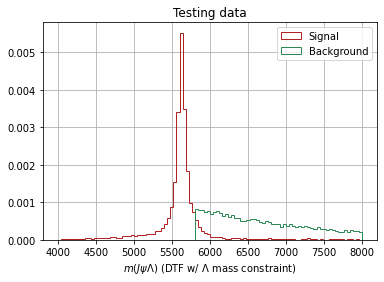

In [28]:
plt.hist(df_test.loc[df_test['TYPE'] == 1, 'DTF_FixJPsiLambda_Lb_M'],bins=100,range=(4000,8000),
        color='firebrick', label='Signal', density=True, histtype='step')
plt.hist(df_test.loc[df_test['TYPE'] == 0, 'DTF_FixJPsiLambda_Lb_M'],bins=100,range=(4000,8000),
        color='seagreen', label='Background', density=True, histtype='step')
plt.grid()
plt.title("Testing data")
plt.legend()
plt.xlabel("$m(J\psi \Lambda)$ (DTF w/ $\Lambda$ mass constraint)")
plt.show()

# Scan the hyperparameter grid

In [29]:
X_train = df_train.loc[:, features].to_numpy()
Y_train = df_train.loc[:, 'TYPE'].to_numpy()

In [30]:
parameters = {'max_depth'        : list(range(4, 15, 2)),
              'max_features'     : [3, 6, 9],
              'learning_rate'    : [0.05, 0.1, 0.2],
              'subsample'        : [0.7, 1.0],
              'n_estimators'     : [1000]} #50, 200, 500
n_jobs = 10

In [31]:
BDT = ensemble.GradientBoostingClassifier(random_state=2021)   
grid_search = model_selection.GridSearchCV(
    BDT,
    parameters,
    scoring='average_precision',
    n_jobs=n_jobs,
    verbose=1000,
    return_train_score=True
)

In [32]:
if do_grid_search:
    grid_search.fit(X_train, Y_train)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results.to_csv(cv_results_file_name, index=False)
else:
    cv_results = pd.read_csv(cv_results_file_name)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 